<a href="https://colab.research.google.com/github/Camilo-Kovacs/data-analysis-python/blob/master/FACTURACION_(FST)_SINIESTROS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import datetime
import re
from datetime import timedelta
from datetime import date
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cargar los datos del archivo Excel
df = pd.read_excel('/content/drive/MyDrive/Repositorio/FacturacionSSTT/Facturacion historica.xlsx', sheet_name='Repositorio FST', na_values=[0])

nuevos_nombres = ["oficina","tipo_orden_trabajo","numero_orden_trabajo","tipo_trabajo","numero_documento_venta","fecha_venta","numero_siniestro","numero_orden","numero_correlacion","codigo_recepcionista","agente_confirmo_7d","fecha_apertura_orden_trabajo","fecha_termino_orden_trabajo","detalle_factura","rut_cliente","nombre_cliente","patente","marca","modelo","total_costo","total_neto_mano_obra","total_neto_repuestos","total_neto_accesorios","total_neto_lubricantes","total_neto_materiales","total_neto_otros","total_neto_documento","total_bruto_documento","cantidad_litros_lubricantes","forma_pago","vin","tipo_venta","tipo_mantenimiento","kilometros_vehiculo","posee_mpp","id_agente","numero_presupuesto", "destinatario_kovcas"]
df.columns = nuevos_nombres 

df["numero_siniestro"].fillna(0, inplace=True)


# eliminar los registros donde la columna numero_siniestro es NaN o None
df = df[df['numero_siniestro'].notna()]

# convertir la columna numero_siniestro de tipo float a int
df['numero_siniestro'] = df['numero_siniestro'].astype(int)


In [ ]:
df_RESPALDO = df.copy()

In [ ]:
df = df_RESPALDO.copy()

In [ ]:
df.shape


(556788, 38)

## PASOS PARA LA NORMALIZACION DE DATA (1)

In [ ]:
#Se crea columna contiene obd y se pasa a mayusculas lo que es detalle_factura
df= df.assign(total_ingresos = ((df['total_neto_accesorios'] + df['total_neto_lubricantes'] + df['total_neto_materiales'] + df['total_neto_repuestos']) - df['total_costo']) + df['total_neto_mano_obra'])

In [ ]:
df['total_facturacion'] = df['total_neto_accesorios'] + df['total_neto_lubricantes'] + df['total_neto_materiales'] + df['total_neto_repuestos'] + df['total_neto_mano_obra']

In [ ]:
df['año_venta'] = pd.DatetimeIndex(df['fecha_venta']).year

In [ ]:
df['mes_venta'] = pd.DatetimeIndex(df['fecha_venta']).month

In [ ]:
df['detalle_factura'].fillna('N/A', inplace=True)

df['contiene_obd'] = np.where(df['detalle_factura'].str.contains("OBD|ANTICLO", na=False), 'SI', 'NO')

In [ ]:
#Se Agrega La Columna Nota Credito
df['nota_credito'] = np.where(df['total_neto_repuestos'] >= 0, 'SIN NC', 'CON NC')

In [ ]:
df['oficina'] = df['oficina'].str.upper()
def asignar_unidad_negocios(oficina):
    if "NISSAN" in oficina:
        return "NISSAN"
    elif "TOYOTA" in oficina:
        return "TOYOTA"
    elif "DYP" in oficina:
        return "DYP"
    else:
        return "CHEVROLET"

df["unidad_negocios"] = df["oficina"].apply(asignar_unidad_negocios)

In [ ]:
#Agregar columna tipo cliente
# df['tipo_cliente'] = df['nombre_cliente'].apply(lambda x: 'SEGURO' if 'SEGURO' in str(x) else 'GENERAL')

df['tipo_cliente'] = df['nombre_cliente'].apply(lambda x: 'SEGURO' if ('SEGURO' in str(x) or 'ASEGURADORA' in str(x)) else 'GENERAL')


In [ ]:
#Cambiar tipificacion de acuerdo a condicion
df.loc[df['posee_mpp'] == 'SI', 'tipo_trabajo'] = 'Mant. Prev.'

In [ ]:
# Se re tipifica la columna Tipo Trabajo
df['tipo_trabajo'] = df['tipo_trabajo'].replace(["Acc. u otros", "Accesorios", "Corr.,Acc. u otros"], "CORRECTIVA")
df['tipo_trabajo'] = df['tipo_trabajo'].replace(["Mant. Prev."], "PREVENTIVA")
df['tipo_trabajo'] = df['tipo_trabajo'].replace(["CRÉDITO"], "CREDITO")
df['tipo_trabajo'] = df['tipo_trabajo'].replace(["GARANTÍA"], "GARANTIA")

In [ ]:
# Se reemplan todos los Valores en la columna tiene_mpp de SI a NO en caso que el registro tenga MPP 
df.loc[df['contiene_obd'] == 'SI', 'posee_mpp'] = 'NO' 

In [ ]:
# Se reemplan todos los Valores en la columna tiene_mpp de SI a NO en caso que el registro tenga MPP 
# df.loc[df['contiene_obd'] == 'SI', 'posee_mpp'] = 'NO' 

# Se reemplan todos los Valores en la columna tiene_mpp de SI a NO en caso que el registro tenga MPP 
df.loc[df['contiene_obd'] == 'SI', 'tipo_trabajo'] = 'CORRECTIVA' 

In [ ]:
#Se normaliza la data en la columna *Tipo Trabajo*
df['tipo_trabajo'] = df['tipo_trabajo'].str.replace('Á', 'A').str.replace('É', 'E').str.replace('Í', 'I').str.replace('Ó', 'O').str.replace('Ú', 'U').str.upper()
df['tipo_trabajo'] = df['tipo_trabajo'].replace(np.nan, 'sin_tipo_trabajo', regex=True)

In [ ]:
#Se normaliza la data en la columna *Tipo Trabajo*
df['tipo_orden_trabajo'] = df['tipo_orden_trabajo'].str.replace('Á', 'A').str.replace('É', 'E').str.replace('Í', 'I').str.replace('Ó', 'O').str.replace('Ú', 'U').str.upper()
df['tipo_orden_trabajo'] = df['tipo_orden_trabajo'].replace(np.nan, 'sin_orden_trabajo', regex=True)

In [ ]:
# Se normaliza la data en la columna Tipo Orden Trabajo
df['tipo_orden_trabajo'].fillna('N/A', inplace=True)
df['tipo_orden_trabajo'] = df['tipo_orden_trabajo'].str.replace('Á', 'A').str.replace('É', 'E').str.replace('Í', 'I').str.replace('Ó', 'O').str.replace('Ú', 'U').str.upper()
df['tipo_orden_trabajo'] = df['tipo_orden_trabajo'].replace(np.nan, 'sin_tipo_orden_trabajo', regex=True)

In [ ]:
# Se genera una nueva columna con TIPO VENTA OT
df["tipo_venta_ot"] = np.where(df["tipo_venta"].str.contains(re.compile("REPTOS|ANT.RPTO|CUP. MPP|RENTACAR|ANT.REPA|CHATARRA|GRUA|Deduc|CAFETERÍ|MISCELÁN",re.IGNORECASE)), "NO", "SI")

In [ ]:
#Se Reemplaza los valores del tipo venta OT
df['tipo_venta_ot'] = df['tipo_venta_ot'].replace({'SI': 'VENTAS CON OT', 'NO': 'OTRAS VENTAS'})

In [ ]:
#Se reemplaza los valores de la columna tipo Orden de Trabajo
df['tipo_orden_trabajo'] = df['tipo_orden_trabajo'].replace({'SIN_TIPO_ORDEN_TRABAJO': 'OTRAS VENTAS'})

In [ ]:
df['tipo_orden_trabajo'].replace('SIN_ORDEN_TRABAJO', 'MISCELANEA', inplace=True)
df['tipo_trabajo'].replace('sin_tipo_trabajo', 'MISCELANEA', inplace=True)

In [ ]:

df.loc[(df['contiene_obd'] == 'SI') & ((df['tipo_orden_trabajo'] == 'GARANTIA') | (df['tipo_orden_trabajo'] == 'PREENTREGA')), 'tipo_orden_trabajo'] = 'MECANICA' 

In [ ]:
#Contar OT
df['contar_ot'] = np.where(df['tipo_venta_ot'] == 'VENTAS CON OT', 1, 0)


In [ ]:
df['vin'] = df['vin'].astype(str)

def clean_vin(vin):
    if len(vin) != 17:
        return ''
    return vin

df['vin'] = df['vin'].apply(clean_vin)

In [ ]:
df['patente'] = df['patente'].astype(str)

def clean_patente(patente):
    if len(patente) != 7:
        return ''
    return patente

df['patente'] = df['patente'].apply(clean_patente)

In [ ]:
df['vin_patente'] = np.where(df['vin'] == "", df['patente'], df['vin'])

In [ ]:
df['numero_siniestro'] = df['numero_siniestro'].astype(str)

df = df[~df['numero_siniestro'].astype(str).str.contains('^0$')]

df['siniestro_patente'] = df['numero_siniestro'].astype(str) + df['patente']

<ipython-input-156-4557edce8d2c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['siniestro_patente'] = df['numero_siniestro'].astype(str) + df['patente']


## SEGMENTAR POR SINIESTRO

In [ ]:

# Filtrar los registros con tipo_cliente igual a "SEGURO" o "GENERAL"
df_filtrado = df[df.tipo_cliente.isin(["SEGURO", "GENERAL"])]

# Convertir la columna fecha_venta a tipo datetime
df_filtrado['fecha_venta'] = pd.to_datetime(df_filtrado['fecha_venta'])

# Ordenar los registros por siniestro_patente y fecha_venta descendente
df_filtrado = df_filtrado.sort_values(by=['siniestro_patente', 'fecha_venta'], ascending=[True, False])

# Mantener todos los registros con el mismo siniestro_patente
df_agrupado = df_filtrado.groupby('siniestro_patente').apply(lambda x: x)



df_agrupado[['total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']] = df_agrupado[['total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']].apply(pd.to_numeric)

df_agrupado[['total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']] = df_agrupado.groupby('siniestro_patente')[['total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']].transform('sum')



# Seleccionar el registro con tipo_cliente igual a "SEGURO" y la fecha_venta más reciente
df_agrupado = df_agrupado[(df_agrupado.tipo_cliente == 'SEGURO')].sort_values(by=['siniestro_patente', 'fecha_venta'], ascending=[True, False]).drop_duplicates(subset='siniestro_patente', keep='first')

# Seleccionar las columnas necesarias
df_agrupado = df_agrupado[['oficina', 'tipo_orden_trabajo', 'tipo_trabajo', 'fecha_venta', 'numero_siniestro', 'numero_orden', 'fecha_apertura_orden_trabajo', 'fecha_termino_orden_trabajo', 'rut_cliente', 'nombre_cliente', 'patente', 'marca', 'modelo', 'forma_pago', 'vin', 'tipo_mantenimiento', 'posee_mpp', 'contiene_obd', 'nota_credito', 'unidad_negocios', 'tipo_cliente', 'contar_ot', 'vin_patente', 'siniestro_patente', 'total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']]


<ipython-input-171-d174309904d6>:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_agrupado = df_filtrado.groupby('siniestro_patente').apply(lambda x: x)


In [ ]:

# Filtrar los registros con tipo_cliente igual a "SEGURO" o "GENERAL"
# df_filtrado = df[df.tipo_cliente.isin(["SEGURO", "GENERAL"])]

# Convertir la columna fecha_venta a tipo datetime
# df_filtrado['fecha_venta'] = pd.to_datetime(df_filtrado['fecha_venta'])

# Ordenar los registros por siniestro_patente y fecha_venta descendente
# df_filtrado = df_filtrado.sort_values(by=['siniestro_patente', 'fecha_venta'], ascending=[True, False])

# Mantener todos los registros con el mismo siniestro_patente
df_agrupado_general = df_filtrado.groupby('siniestro_patente').apply(lambda x: x)



df_agrupado_general[['total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']] = df_agrupado_general[['total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']].apply(pd.to_numeric)

df_agrupado_general[['total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']] = df_agrupado_general.groupby('siniestro_patente')[['total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']].transform('sum')



# Seleccionar el registro con tipo_cliente igual a "SEGURO" y la fecha_venta más reciente
df_agrupado_general = df_agrupado_general[(df_agrupado_general.tipo_cliente == 'GENERAL')].sort_values(by=['siniestro_patente', 'fecha_venta'], ascending=[True, False]).drop_duplicates(subset='siniestro_patente', keep='first')

# Seleccionar las columnas necesarias
df_agrupado_general = df_agrupado_general[['oficina', 'tipo_orden_trabajo', 'tipo_trabajo', 'fecha_venta', 'numero_siniestro', 'numero_orden', 'fecha_apertura_orden_trabajo', 'fecha_termino_orden_trabajo', 'rut_cliente', 'nombre_cliente', 'patente', 'marca', 'modelo', 'forma_pago', 'vin', 'tipo_mantenimiento', 'posee_mpp', 'contiene_obd', 'nota_credito', 'unidad_negocios', 'tipo_cliente', 'contar_ot', 'vin_patente', 'siniestro_patente', 'total_ingresos', 'total_facturacion', 'total_costo', 'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios', 'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros', 'total_neto_documento', 'total_bruto_documento']]


<ipython-input-173-d39ce9377fa1>:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_agrupado_general = df_filtrado.groupby('siniestro_patente').apply(lambda x: x)


In [ ]:
df_siniestros.tipo_cliente.sample(5)

17321     SEGURO
9870      SEGURO
21598    GENERAL
19867    GENERAL
8780      SEGURO
Name: tipo_cliente, dtype: object

In [ ]:
df_siniestros = pd.concat([df_agrupado, df_agrupado_general], ignore_index=True)


In [ ]:
df_siniestros.to_excel("SiniestroSSTT.xlsx", index=False)

In [ ]:
# df_agrupado.to_excel("SiniestroSSTT.xlsx", index=False)

In [ ]:
# df_siniestros.sample(5)

In [ ]:
# df_siniestros.to_excel("SiniestroSSTT.xlsx", index=False)

## PARA EXPORTAR A EXCEL

In [ ]:
#df.to_excel("facturacion.xlsx", index=False)

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
print("tipo_cliente" in df.columns)

True


## OBTENER ANALISIS SI TUVO OBDII

In [ ]:
df['contiene_obd'] = df['contiene_obd'].map({'SI': 1, 'NO': 0})

df['tuvo_obd'] = np.where(df.groupby('vin')['contiene_obd'].transform('sum') > 0, 'SI TUVO', 'NO TUVO')

In [ ]:
df_filtered = df[df['vin'] == '3N1AB7AD6KL601754']
df_filtered

In [ ]:
df_obd_nissan = df[df['unidad_negocios'] == 'NISSAN']

df_obd_nissan.to_excel("df_obd_nissan.xlsx", index=False)

## OBTENER COLUMNA CON LA ULTIMA MANTENCION REALIZADA

In [ ]:
df['ultima_mantencion'] = np.nan
df['ultima_fecha'] = np.nan

mask = df['tipo_mantenimiento'] != 0
grouped = df[mask].groupby('vin')

results = []
for name, group in grouped:
    max_date = group['fecha_venta'].idxmax()
    row = {
        'vin': name,
        'ultima_mantencion': group['tipo_mantenimiento'].max(),
        'ultima_fecha': group['fecha_venta'].max()
    }
    results.append(row)

results_df = pd.DataFrame(results)
df = df.merge(results_df, on='vin', how='left')


In [ ]:
df.info()

In [ ]:
df.head(10)

## ULTIMO ESTADO BBDD SSTT

In [ ]:
df.head(10)

In [ ]:
df.columns

In [ ]:
# ACA SE REALIZA LA AGRUPACION Y LA SEGEMNTACION 

# df.sort_values(["fecha_venta","numero_orden_trabajo"], ascending=[False,False], inplace=True)
# df_ultimoEstado = df.groupby("vin").first().reset_index()

In [ ]:
# df_ultimoEstado = df_ultimoEstado.astype(str)
# df_ultimoEstado["fecha_venta"] = pd.to_datetime(df_ultimoEstado["fecha_venta"], format="%Y-%m-%d")
# df_ultimoEstado.to_excel("UltimoEstadoSSTT.xlsx", index=False)

In [ ]:

df.to_excel("Siniestro.xlsx", index=False)

In [ ]:
# df_filtered = df_ultimoEstado[df_ultimoEstado['vin'] == '3N1AB8AE0NY221914']
# df_filtered

In [ ]:
# df_filtered = df[df['vin'] == '3G1M95EF0ML116284']
# df_filtered

## CONSULTAS PARA EXTRAER AIRLIFE - TAKATA

In [ ]:
df_airlife = df.copy()
df_airlife['contiene_airlife'] = np.where(df_airlife['detalle_factura'].str.contains("TAKATA|AIRBAG|AIR BAG|AIR-BAG|INFLADOR|AIR  BAG|BOLSA DE AIRE", na=False), 'SI', 'NO')
#df_airlife.to_excel("2022_airlife.xlsx", index=False)
df_filtrado = df_airlife.query("contiene_airlife == 'SI'")
df_filtrado.to_excel("2022_airlife.xlsx", index=False)



In [ ]:
df_airlife.columns

## PASOS PARA NORMALIZAR DATA (ANTIGUA) 

In [ ]:
# 1.1 Generar Nuevos Nombres de las Columnas 
nuevos_nombres = ["oficina","tipo_orden_trabajo","numero_orden_trabajo","tipo_trabajo","numero_documento_venta","fecha_venta","numero_siniestro","numero_orden","numero_correlacion","codigo_recepcionista","agente_confirmo_7d","fecha_apertura_orden_trabajo","fecha_termino_orden_trabajo","detalle_factura","rut_cliente","nombre_cliente","patente","marca","modelo","total_costo","total_neto_mano_obra","total_neto_repuestos","total_neto_accesorios","total_neto_lubricantes","total_neto_materiales","total_neto_otros","total_neto_documento","total_bruto_documento","cantidad_litros_lubricantes","forma_pago","vin","tipo_venta","tipo_mantenimiento","kilometros_vehiculo","posee_mpp","id_agente","numero_presupuesto", "destinatario_kovcas"]
df.columns = nuevos_nombres


In [ ]:
#1.X Se crea la columna UNIDAD DE NEGOCIOS

df['oficina'] = df['oficina'].str.upper()
def asignar_unidad_negocios(oficina):
    if "NISSAN" in oficina:
        return "NISSAN"
    elif "TOYOTA" in oficina:
        return "TOYOTA"
    elif "DYP" in oficina:
        return "DYP"
    else:
        return "CHEVROLET"

df["unidad_negocios"] = df["oficina"].apply(asignar_unidad_negocios)

In [ ]:
#1.2 Se crea Columna Total Ingresos
df= df.assign(total_ingresos = ((df['total_neto_accesorios'] + df['total_neto_lubricantes'] + df['total_neto_materiales'] + df['total_neto_repuestos']) - df['total_costo']) + df['total_neto_mano_obra'])



In [ ]:
#1.3 Se Genera la columna Total Facturación
df['total_facturacion'] = df['total_neto_accesorios'] + df['total_neto_lubricantes'] + df['total_neto_materiales'] + df['total_neto_repuestos'] + df['total_neto_mano_obra']



In [ ]:
#1.3 Se Normaliza Detalle Facturacion y se crea la Columna OBD  SI o NO son con OBD

df['detalle_factura'].fillna('N/A', inplace=True)

df['contiene_obd'] = np.where(df['detalle_factura'].str.contains("OBD|ANTICLO", na=False), 'SI', 'NO')

In [ ]:
# 1.x Se crea la Columna NOTA DE CREDITO

df['nota_credito'] = np.where(df['total_neto_repuestos'] >= 0, 'SIN NC', 'CON NC')


In [ ]:
# 1.X Se crea la columan TIPO DE CLIENTES

df['tipo_cliente'] = df['detalle_factura'].apply(lambda x: 'SEGURO' if 'SEGURO' in str(x) else 'GENERAL')



In [ ]:
#Cambiar tipificacion de acuerdo a condicion

df.loc[df['posee_mpp'] == 'SI', 'tipo_trabajo'] = 'Mant. Prev.'


In [ ]:
# Se re tipifica la columna Tipo Trabajo

df['tipo_trabajo'] = df['tipo_trabajo'].replace(["Acc. u otros", "Accesorios", "Corr.,Acc. u otros"], "CORRECTIVA")
df['tipo_trabajo'] = df['tipo_trabajo'].replace(["Mant. Prev."], "PREVENTIVA")
df['tipo_trabajo'] = df['tipo_trabajo'].replace(["CRÉDITO"], "CREDITO")
df['tipo_trabajo'] = df['tipo_trabajo'].replace(["GARANTÍA"], "GARANTIA")

In [ ]:
# Se reemplan todos los Valores en la columna tiene_mpp de SI a NO en caso que el registro tenga MPP 

df.loc[df['contiene_obd'] == 'SI', 'posee_mpp'] = 'NO' 

# Se reemplan todos los Valores en la columna tiene_mpp de SI a NO en caso que el registro tenga MPP 

df.loc[df['contiene_obd'] == 'SI', 'tipo_trabajo'] = 'CORRECTIVA' 

In [ ]:
#Se normaliza la data en la columna *Tipo Trabajo*

df['tipo_trabajo'] = df['tipo_trabajo'].str.replace('Á', 'A').str.replace('É', 'E').str.replace('Í', 'I').str.replace('Ó', 'O').str.replace('Ú', 'U').str.upper()
df['tipo_trabajo'] = df['tipo_trabajo'].replace(np.nan, 'sin_tipo_trabajo', regex=True)

In [ ]:
# Se normaliza la data en la columna Tipo Orden Trabajo

df['tipo_orden_trabajo'].fillna('N/A', inplace=True)
df['tipo_orden_trabajo'] = df['tipo_orden_trabajo'].str.replace('Á', 'A').str.replace('É', 'E').str.replace('Í', 'I').str.replace('Ó', 'O').str.replace('Ú', 'U').str.upper()
df['tipo_orden_trabajo'] = df['tipo_orden_trabajo'].replace(np.nan, 'sin_tipo_orden_trabajo', regex=True)

In [ ]:
# Se genera una nueva columna con TIPO VENTA OT

df["tipo_venta_ot"] = np.where(df["tipo_venta"].str.contains(re.compile("REPTOS|ANT.RPTO|CUP. MPP|RENTACAR|ANT.REPA|CHATARRA|GRUA|Deduc|CAFETERÍ|MISCELÁN",re.IGNORECASE)), "NO", "SI")



In [ ]:
#Se Reemplaza los valores del tipo venta OT

df['tipo_venta_ot'] = df['tipo_venta_ot'].replace({'SI': 'VENTAS CON OT', 'NO': 'OTRAS VENTAS'})


In [ ]:
#Se reemplaza los valores de la columna tipo Orden de Trabajo

df['tipo_orden_trabajo'] = df['tipo_orden_trabajo'].replace({'SIN_TIPO_ORDEN_TRABAJO': 'OTRAS VENTAS'})


In [ ]:
# 1.X Se remplaza registors de acuerdo a la condición de las columnas (SE GENERA EL CONCEPTO MESCELANEAS)

df['tipo_orden_trabajo'].replace('SIN_ORDEN_TRABAJO', 'MISCELANEA', inplace=True)
df['tipo_trabajo'].replace('sin_tipo_trabajo', 'MISCELANEA', inplace=True)

In [ ]:
df.loc[(df['contiene_obd'] == 'SI') & ((df['tipo_orden_trabajo'] == 'GARANTIA') | (df['tipo_orden_trabajo'] == 'PREENTREGA')), 'tipo_orden_trabajo'] = 'MECANICA'

In [ ]:
df['año_venta'] = pd.DatetimeIndex(df['fecha_venta']).year

In [ ]:
#Genero una copia en caso que las prueba no sean la ideales
df_ = df.copy()
#Para volver a al df origina
#df = df_.copy()

In [ ]:
#df.to_excel("data.xlsx", index=False)

In [ ]:
#df.to_csv("data.csv", index=False)

## CONSULTAS **VARIAS**

In [ ]:
df.columns

Index(['oficina', 'tipo_orden_trabajo', 'numero_orden_trabajo', 'tipo_trabajo',
       'numero_documento_venta', 'fecha_venta', 'numero_siniestro',
       'numero_orden', 'numero_correlacion', 'codigo_recepcionista',
       'agente_confirmo_7d', 'fecha_apertura_orden_trabajo',
       'fecha_termino_orden_trabajo', 'detalle_factura', 'rut_cliente',
       'nombre_cliente', 'patente', 'marca', 'modelo', 'total_costo',
       'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios',
       'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros',
       'total_neto_documento', 'total_bruto_documento',
       'cantidad_litros_lubricantes', 'forma_pago', 'vin', 'tipo_venta',
       'tipo_mantenimiento', 'kilometros_vehiculo', 'posee_mpp', 'id_agente',
       'numero_presupuesto', 'destinatario_kovcas', 'total_ingresos',
       'total_facturacion', 'año_venta', 'mes_venta', 'contiene_obd',
       'nota_credito', 'unidad_negocios', 'tipo_cliente', 'tipo_venta_ot',


###Contar el número de ordenes de trabajo por oficina:

In [ ]:
df.groupby('oficina')['oficina'].count()

oficina
LINARES               6314
LINARES TOYOTA        3269
QUILLOTA              7366
QUILLOTA NISSAN       2882
SAN FELIPE            7778
SAN FELIPE TOYOTA     2053
STGO BUST. DYP        3168
STGO HUECH. DYP       1390
STGO MOVICENTER      11117
STGO PLAZA SUR        5289
STGO SEM. TOYOTA      6018
STGO SEMINARIO       19094
STGO TOBALABA         5005
TALCA                10211
TALCA TOYOTA          5306
VALPARAÍSO            9342
VALPO DYP             2948
VALPO NISSAN          4121
VIÑA DEL MAR          8780
VIÑA NISSAN           6182
Name: oficina, dtype: int64

###Obtener el total de ventas por tipo de trabajo:

---



In [ ]:
df.groupby('tipo_trabajo')['total_ingresos'].sum()

tipo_trabajo
Acc. u otros              559340
Accesorios              55942711
Corr.,Acc. u otros     815892295
Crédito                   232627
DyP                   1816212303
Garantía               949391351
Mant. Prev.           2611757832
Preentrega             271053289
Name: total_ingresos, dtype: int64

###Obtener el total de ventas por cada agente:

In [ ]:
df.groupby('codigo_recepcionista')['total_ingresos'].sum()

###Obtener el número de siniestros por tipo de orden de trabajo:

In [ ]:
df.groupby('tipo_orden_trabajo')['numero_siniestro'].count()

###Filtrar las ordenes de trabajo que fueron confirmadas por agentes en los últimos 7 días:

In [ ]:
df[df['agente_confirmo_7d'] == True]

###Obtener el total de ventas por mes:

In [ ]:
df.groupby(df['fecha_venta'].dt.month)['total_ingresos'].sum()

###7.Obtener la cantidad de veces que se ha vendido cada marca de vehículo:

In [ ]:
df['marca'].value_counts()

###8.Obtener el total de costos de repuestos por orden de trabajo:

In [ ]:
df.groupby('numero_orden_trabajo')['total_neto_repuestos'].sum()

###9.Obtener el promedio de la cantidad de litros de lubricantes vendidos por orden de trabajo:

In [ ]:
df.groupby('numero_orden_trabajo')['cantidad_litros_lubricantes'].mean()

###10.Obtener el total de ventas por forma de pago:

In [ ]:
df.groupby('forma_pago')['total_ingresos'].sum()

In [ ]:
df[['fecha_apertura_orden_trabajo','fecha_termino_orden_trabajo','fecha_venta']] = df[['fecha_apertura_orden_trabajo','fecha_termino_orden_trabajo','fecha_venta']].apply(pd.to_datetime)

In [ ]:
df['fecha_apertura_orden_trabajo'] = pd.to_datetime(df['fecha_apertura_orden_trabajo'])

###11.Filtrar las ordenes de trabajo que fueron abiertas en los últimos 30 días:

In [ ]:
df[(df['fecha_venta'] >= (pd.datetime.now() - timedelta(days=30)))]

In [ ]:
df[(df['fecha_venta'] >= (pd.datetime.now() - timedelta(days=7)))]

In [ ]:
df[(pd.to_datetime(df['fecha_venta']) >= (pd.to_datetime(date.today()) - timedelta(days=7)))]

In [ ]:
df[(pd.to_datetime(df['fecha_venta']) >= (pd.to_datetime(date.today()) - timedelta(days=30)))]

In [ ]:
df[['fecha_apertura_orden_trabajo','fecha_termino_orden_trabajo','fecha_venta']] = df[['fecha_apertura_orden_trabajo','fecha_termino_orden_trabajo','fecha_venta']].apply(pd.to_datetime)

###12.Obtener el total de ventas por cada destinatario de Kovcas:

In [ ]:
df.groupby('destinatario_kovcas')['total_ingresos'].sum()

###13. Obtener el número de vehículos con mantenimiento programado

In [ ]:
df[df['posee_mantenimiento'] == "NO"].count()

###14. Obtener el total de ventas por cada agente:

In [ ]:
df.groupby('id_agente')['total_ingresos'].sum()

###15.Filtrar las ordenes de trabajo que fueron terminadas en los últimos 7 días

In [ ]:
df[(df['fecha_venta'] >= (pd.to_datetime(date.today()) - timedelta(days=7)))]

In [ ]:
df[(df['fecha_venta'] >= (pd.datetime.now() - timedelta(days=7)))]

###16. Obtener el total de ventas por tipo de venta:

In [ ]:
df.groupby('tipo_venta')['total_ingresos'].sum()

###17.Obtener el número de vehículos por cada marca:

In [ ]:
df['marca'].value_counts()

###18.Obtener el total de ventas por tipo de mantenimiento:

In [ ]:
df.groupby('tipo_mantenimiento')['total_ingresos'].sum()

###19.Obtener el promedio de kilómetros de los vehículos en orden de trabajo:

In [ ]:
df['kilometros_vehiculo'].mean()

###20.Obtener el total de ventas por número de presupuesto:

In [ ]:
df.groupby('numero_presupuesto')['total_ingresos'].sum()

###1.1.btener el total de ventas por cada tipo de orden de trabajo:

In [ ]:
df.groupby('tipo_orden_trabajo')['total_ingresos'].sum()

###Filtrar las ordenes de trabajo por un rango de fechas específico:


In [ ]:
df[(df['fecha_venta'] >= '2022-01-01') & (df['fecha_venta'] <= '2022-12-31')]

###Obtener el total de ventas por cada modelo de vehículo:


In [ ]:
df.groupby('modelo')['total_ingresos'].sum()

###Obtener el número de ordenes de trabajo por cada tipo de venta:

In [ ]:
df.groupby('tipo_venta')['numero_orden_trabajo'].count()

###Obtener el total de ventas por cada tipo de mantenimiento:


In [ ]:
df.groupby('tipo_mantenimiento')['total_ingresos'].sum()

###Filtrar las ordenes de trabajo por un número de siniestro específico:


In [ ]:
df[df['numero_siniestro'] == '12345']

###Obtener el total de ventas por cada nombre de cliente:


In [ ]:
df.groupby('nombre_cliente')['total_ingresos'].sum()

###Obtener el total de ventas por cada patente de vehículo:

In [ ]:
df.groupby('patente')['total_ingresos'].sum()

###9.1.Filtrar las ordenes de trabajo por un número de orden específico:

In [ ]:
df[df['numero_orden'] == '98765']

###10.1 Obtener el total de ventas por cada forma de pago:

In [ ]:
df.groupby('forma_pago')['total_ingresos'].sum()

## Reordennamiento de columnas para sacar el ultimo estado por VIN o Patente

### 10.2 Reordenar Columnas::

---



In [ ]:
df = df.reindex(columns=['oficina', 'patente', 'tipo_orden_trabajo', 'numero_orden_trabajo', 'tipo_trabajo',
       'numero_documento_venta', 'fecha_venta', 'numero_siniestro',
       'numero_orden', 'numero_correlacion', 'codigo_recepcionista',
       'agente_confirmo_7d', 'fecha_apertura_orden_trabajo',
       'fecha_termino_orden_trabajo', 'detalle_factura', 'rut_cliente',
       'nombre_cliente',  'marca', 'modelo', 'total_costo',
       'total_neto_mano_obra', 'total_neto_repuestos', 'total_neto_accesorios',
       'total_neto_lubricantes', 'total_neto_materiales', 'total_neto_otros',
       'total_neto_documento', 'total_bruto_documento',
       'cantidad_litros_lubricantes', 'forma_pago', 'vin', 'tipo_venta',
       'tipo_mantenimiento', 'kilometros_vehiculo', 'posee_mantenimiento',
       'id_agente', 'numero_presupuesto', 'destinatario_kovcas',
       'total_ingresos'])

## SUMATORIAS

###10.3 Obtener el ultimo listado de cada Patente con su ultima Facturacion

In [ ]:
df.sort_values(by='fecha_venta',ascending=False).groupby('patente').tail(1)

###10.4 Obtener el Total Ingreso del año 2023 (Sin Formato)

In [ ]:
df.loc[df['fecha_venta'].dt.year == 2023, 'total_ingreso'].sum()


690007247

###10.5 Obtener el Totales del año 2023 (Con Formato)

In [ ]:
print("Total Ingresos: ${:,.2f}".format(df.loc[df['fecha_venta'].dt.year == 2023, 'total_ingresos'].sum()))

In [ ]:
print("Facturacion: ${:,.2f}".format(df.loc[df['fecha_venta'].dt.year == 2023, 'total_facturacion'].sum()))

Facturacion: $1,632,617,276.00


###10.6 Obtener el Totales del año 2023 y de Sucursal (Linares) (Sin Formato)

In [ ]:
df.loc[(df['fecha_venta'].dt.year == 2023) & (df['oficina'] == 'Linares'), 'total_ingresos'].sum()

38868435

###10.7 Obtener cantidad de registros[texto del enlace](https://) de Sucursal (Linares) (Sin Formato)

In [ ]:
df.loc[df['oficina'] == 'Linares'].shape[0]


3414

###10.8 Generar columna Total Facturación

In [ ]:
print("Facturacion: ${:,.2f}".format(df.loc[df['fecha_venta'].dt.year == 2023, 'total_facturacion'].sum()))

Facturacion: $1,632,617,276.00


In [ ]:
print("El total de facturación es: ${:,.0f}".format(df['total_facturacion'].sum()))

El total de facturación es: $15,611,789,153


In [ ]:
df_2023 = df.query("fecha_venta.dt.year == 2023")
print("El total de facturación en el año 2023 es: ${:,.0f}".format(df_2023['total_facturacion'].sum()))


El total de facturación en el año 2023 es: $1,632,617,276


In [ ]:
total_facturacion_2023 = df.loc[df['fecha_venta'].dt.year == 2023, 'total_facturacion'].sum()
print("Total facturacion 2023: ${:,.2f}".format(total_facturacion_2023))


Total facturacion 2023: $1,632,617,276.00


In [ ]:
total = df.loc[df['fecha_venta'].dt.year == 2023, 'total_facturacion'].sum()
print("Total facturación: ${:,.0f}".format(total))

Total facturación: $1,632,617,276


###10.9 Obtener Total Facturacion por Oficina

In [ ]:
# Agrupar por las columnas deseadas
df_grouped = df.groupby(['oficina'])[['total_facturacion','total_neto_mano_obra','total_neto_repuestos','total_neto_lubricantes','total_ingresos']].sum().reset_index()

# Renombrar las columnas
df_grouped = df_grouped.rename(columns={'total_facturacion':'Total Facturacion',
                                       'total_neto_mano_obra':'Mano de Obra',
                                       'total_neto_repuestos':'Total Repuestos',
                                       'total_neto_lubricantes':'Total Lubricantes',
                                       'total_ingresos':'Total Ingresos'})
df_grouped


###10.10 Obtener Totales por Columnas Totales Netos 


In [ ]:
table = df.agg({
    'total_facturacion': 'sum',
    'total_neto_mano_obra': 'sum',
    'total_neto_repuestos': 'sum',
    'total_neto_lubricantes': 'sum',
    'total_ingresos': 'sum'
}).rename_axis('Total').reset_index()
print(table)

                    Total            0
0       total_facturacion  15704814516
1    total_neto_mano_obra   2922605207
2    total_neto_repuestos  10715637987
3  total_neto_lubricantes   1323990179
4          total_ingresos   6446978339


In [ ]:
table = df[['total_facturacion','total_neto_mano_obra','total_neto_repuestos','total_neto_lubricantes','total_ingresos']]
table = table.agg(['sum'])
table = table.T
table = table.rename(columns = {'sum':'Total'})
table

###10.11 Obtener Total por Oficina y aplicar formato $

In [ ]:
# convertir la columna fecha_venta a tipo datetime
df['fecha_venta'] = pd.to_datetime(df['fecha_venta'])

# filtrar solo las filas del año 2023
df_2023 = df[df['fecha_venta'].dt.year == 2023]

# Agrupar por las columnas deseadas
df_grouped = df_2023.groupby(['oficina'])[['total_facturacion','total_neto_mano_obra','total_neto_repuestos','total_neto_lubricantes','total_ingresos']].sum().reset_index()

# Renombrar las columnas
df_grouped = df_grouped.rename(columns={'total_facturacion':'Total Facturacion',
                                       'total_neto_mano_obra':'Mano de Obra',
                                       'total_neto_repuestos':'Total Repuestos',
                                       'total_neto_lubricantes':'Total Lubricantes',
                                       'total_ingresos':'Total Ingresos'})

# aplicar formato de moneda a las columnas
df_grouped['Total Facturacion'] = df_grouped['Total Facturacion'].apply(lambda x: "${:,.0f}".format(x))
df_grouped['Mano de Obra'] = df_grouped['Mano de Obra'].apply(lambda x: "${:,.0f}".format(x))
df_grouped['Total Repuestos'] = df_grouped['Total Repuestos'].apply(lambda x: "${:,.0f}".format(x))
df_grouped['Total Lubricantes'] = df_grouped['Total Lubricantes'].apply(lambda x: "${:,.0f}".format(x))
df_grouped['Total Ingresos'] = df_grouped['Total Ingresos'].apply(lambda x: "${:,.0f}".format(x))


In [ ]:
df_2023 = df.loc[df['fecha_venta'].dt.year == 2023]
df_grouped = df_2023.groupby(['oficina'])[['total_facturacion','total_neto_mano_obra','total_neto_repuestos','total_neto_lubricantes','total_ingresos']].sum().reset_index()
df_grouped["total_facturacion"] = df_grouped["total_facturacion"].apply(lambda x: "${:,.0f}".format(x))
df_grouped["total_neto_mano_obra"] = df_grouped["total_neto_mano_obra"].apply(lambda x: "${:,.0f}".format(x))
df_grouped["total_neto_repuestos"] = df_grouped["total_neto_repuestos"].apply(lambda x: "${:,.0f}".format(x))
df_grouped["total_neto_lubricantes"] = df_grouped["total_neto_lubricantes"].apply(lambda x: "${:,.0f}".format(x))
df_grouped["total_ingresos"] = df_grouped["total_ingresos"].apply(lambda x: "${:,.0f}".format(x))
df_grouped = df_grouped.rename(columns={'total_facturacion':'Total Facturacion',
                                       'total_neto_mano_obra':'Mano de Obra',
                                       'total_neto_repuestos':'Total Repuestos',
                                       'total_neto_lubricantes':'Total Lubricantes',
                                       'total_ingresos':'Total Ingresos'})
df_grouped

###10.12 Obtener Total por Oficina y con formato $

In [ ]:
# Filtro solo para el año 2023
df_2023 = df[df['fecha_venta'].dt.year == 2023]

# Agrupar por las columnas deseadas
df_grouped = df_2023.groupby(['oficina'])[['total_facturacion','total_neto_mano_obra','total_neto_repuestos','total_neto_lubricantes','total_ingresos']].sum().reset_index()

# Renombrar las columnas
df_grouped = df_grouped.rename(columns={'total_facturacion':'Total Facturacion',
                                       'total_neto_mano_obra':'Mano de Obra',
                                       'total_neto_repuestos':'Total Repuestos',
                                       'total_neto_lubricantes':'Total Lubricantes',
                                       'total_ingresos':'Total Ingresos'})

# Agregar el formato de pesos $ y sin decimales
df_grouped[['Total Facturacion','Mano de Obra','Total Repuestos','Total Lubricantes','Total Ingresos']] = df_grouped[['Total Facturacion','Mano de Obra','Total Repuestos','Total Lubricantes','Total Ingresos']].applymap('${:,.0f}'.format)
df_grouped

## OTRAS CONSULTAS:

###10.14 Genera un listado con el total de facturacion por unidad de negocio (Con Formato)

In [ ]:
# Filtro solo para el año 2023
df_2023 = df[df['fecha_venta'].dt.year == 2023]

# Agrupar por las columnas deseadas
df_grouped = df_2023.groupby(['unidad_negocios'])[['total_facturacion','total_neto_mano_obra','total_neto_repuestos','total_neto_lubricantes','total_ingresos']].sum().reset_index()

# Renombrar las columnas
df_grouped = df_grouped.rename(columns={'total_facturacion':'Total Facturacion',
                                       'total_neto_mano_obra':'Mano de Obra',
                                       'total_neto_repuestos':'Total Repuestos',
                                       'total_neto_lubricantes':'Total Lubricantes',
                                       'total_ingresos':'Total Ingresos'})

# Agregar el formato de pesos $ y sin decimales
df_grouped[['Total Facturacion','Mano de Obra','Total Repuestos','Total Lubricantes','Total Ingresos']] = df_grouped[['Total Facturacion','Mano de Obra','Total Repuestos','Total Lubricantes','Total Ingresos']].applymap('${:,.0f}'.format)
df_grouped

,unidad_negocios,Total Facturacion,Mano de Obra,Total Repuestos,Total Lubricantes,Total Ingresos
0,CHEVROLET,"$1,187,619,571","$229,207,185","$762,050,031","$150,483,778","$536,132,728"
1,DYP,"$282,575,504","$51,689,160","$227,708,017",$0,"$106,667,767"
2,NISSAN,"$184,236,101","$46,091,265","$108,268,717","$29,074,487","$81,959,513"
3,TOYOTA,"$215,921,113","$42,001,926","$132,942,628","$14,652,071","$73,549,351"


###10.15 Genera un listado con el total de registros por unidad de negocio (Con Formato)

In [ ]:
df_grouped = df.groupby(['unidad_negocios']).size().reset_index(name='count')
df_grouped

,unidad_negocios,count
0,CHEVROLET,90296
1,DYP,7506
2,NISSAN,13185
3,TOYOTA,16646


### Se crea Colmna Nota de Credito

In [ ]:
df_grouped = df.groupby(['nota_credito']).size().reset_index(name='count')
df_grouped

In [ ]:
df['detalle_factura'] = df['detalle_factura'].str.upper()

### Se crea columna contiene obd y se pasa a mayusculas lo que es detalle_factura

In [ ]:
df['contiene_obd'] = np.where(df['detalle_factura'].str.contains("OBD|ANTICLO", na=False), 'SI', 'NO')

In [ ]:
df_grouped = df.groupby(['contiene_obd']).size().reset_index(name='count')
df_grouped

### Crear columna Año Venta

In [ ]:
df['año_venta'] = pd.DatetimeIndex(df['fecha_venta']).year

### Se genera tabla con los valores abajo filtrados (contiene obd, año = 2023)

In [ ]:
df_filtrado = df.loc[(df['contiene_obd'] == 'SI') & (df['año_venta'] == 2023), ['oficina', 'detalle_factura', 'contiene_obd', 'posee_mpp']]
print(df_filtrado)

In [ ]:
df_2023 = df.loc[(df['año_venta']==2023) & (df['contiene_obd'] == 'SI')]
df_grouped = df_2023.groupby(['unidad_negocios'])[['oficina']].count().reset_index()


# Mostrar el resultado
df_2023

In [ ]:
df['tipo_cliente'] = df['detalle_factura'].apply(lambda x: 'SEGURO' if 'SEGURO' in str(x) else 'GENERAL')

In [ ]:
df_grouped = df.groupby(['tipo_cliente']).size().reset_index(name='count')
df_grouped

In [ ]:
df_grouped = df.groupby(['contiene_obd']).size().reset_index(name='count')
df_grouped

In [ ]:
df.columns

In [ ]:
df_grouped = df.groupby(['tipo_orden_trabajo']).size().reset_index(name='count')
df_grouped

In [ ]:
f_grouped = df.groupby(['tipo_trabajo']).size().reset_index(name='count')
df_grouped


In [ ]:
df.query("contiene_obd == 'SI' & posee_mpp == 'SI'").count()

In [ ]:
df.query("contiene_obd == 'SI' & tipo_trabajo == 'CORRECTIVA'").count()

In [ ]:
df.query("contiene_obd == 'SI' & posee_mpp == 'SI'")["oficina"].count()

In [ ]:
df_original = df.copy()

In [ ]:
df_original.shape

In [ ]:
df.loc[df['contiene_obd'] == 'SI', 'posee_mpp'] = 'NO'

In [ ]:
df_grouped = df.groupby(['tipo_trabajo']).size().reset_index(name='count')
df_grouped


In [ ]:
df = df_original.copy()

In [ ]:
df_grouped = df.groupby(['tipo_venta']).size().reset_index(name='count')
df_grouped


In [ ]:
df_grouped = df['tipo_venta_ot'].value_counts().sort_values(ascending=False)
df_grouped

SI    45894
NO    26712
Name: tipo_venta_ot, dtype: int64

In [ ]:
total_registros = len(df['tipo_venta'])
print("Total de registros: ", total_registros)

Total de registros:  127633


In [ ]:
df_tipo_venta_sin_OT = df[~df['tipo_venta'].str.contains("OT")]['tipo_venta'].unique()
print(df_tipo_venta_sin_OT)

['ANT.RPTO' 'REPTOS' 'CUP. MPP' 'RENTACAR' 'ANT.REPA' 'MISCELÁN' 'GRUA'
 'CHATARRA']


In [ ]:
df.loc[(df['fecha_venta'].dt.year == 2023) & (df['tipo_venta_ot'] == 'otras_ventas'), 'total_ingresos'].sum()

0

In [ ]:
df_grouped = df.groupby(['oficina', 'tipo_orden_trabajo']).size().reset_index(name='count')
df_grouped = df_grouped.pivot(index='oficina', columns='tipo_orden_trabajo', values='count')
df_grouped = df_grouped.fillna(0)
df_grouped['total'] = df_grouped.sum(axis=1)
df_grouped.loc['total'] = df_grouped.sum()
df_grouped

tipo_orden_trabajo,GARANTIA,MECANICA,MISCELANEA,PREENTREGA,total
oficina,,,,,
LINARES,531.0,2628.0,2653.0,502.0,6314.0
LINARES TOYOTA,971.0,930.0,1016.0,352.0,3269.0
QUILLOTA,615.0,3183.0,2833.0,735.0,7366.0
QUILLOTA NISSAN,218.0,1989.0,662.0,13.0,2882.0
SAN FELIPE,584.0,3815.0,2370.0,1009.0,7778.0
SAN FELIPE TOYOTA,572.0,483.0,564.0,434.0,2053.0
STGO BUST. DYP,0.0,2586.0,582.0,0.0,3168.0
STGO HUECH. DYP,0.0,1268.0,122.0,0.0,1390.0
STGO MOVICENTER,1031.0,4208.0,3563.0,2315.0,11117.0


In [ ]:
df_grouped = df['tipo_venta_ot'].value_counts().sort_values(ascending=False)
df_grouped

VENTAS CON OT    79816
OTRAS VENTAS     47817
Name: tipo_venta_ot, dtype: int64

In [ ]:
df_grouped = df.groupby(['tipo_venta_ot']).size().reset_index(name='count')
df_grouped = df_grouped.sort_values(by='count', ascending=False)
df_grouped.head(10)


,tipo_venta_ot,count
1,VENTAS CON OT,79816
0,OTRAS VENTAS,47817


In [ ]:
df_grouped = df.groupby(df['fecha_venta'].dt.day).sum()
dia_con_mas_facturas = df_grouped['total_facturacion'].idxmax()
print("El día con más facturas es: ", dia_con_mas_facturas)



El día con más facturas es:  30


In [ ]:
df_grouped = df.groupby(df['fecha_venta'].dt.day).sum()
df_grouped = df_grouped.sort_values(by='total_facturacion', ascending=False)
dia_mas_facturacion = df_grouped.index[0]
dia_mas_facturacion


30

In [ ]:
df.columns

In [ ]:
df['week_number'] = df['fecha_venta'].dt.week
df_grouped = df.groupby(['week_number'])['total_facturacion'].sum().reset_index(name='total_facturacion')
max_week_number = df_grouped['total_facturacion'].idxmax()
print("El número de la semana con la mayor facturación es:", max_week_number)


El número de la semana con la mayor facturación es: 30


<ipython-input-31-f3ca0d19b58e>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_number'] = df['fecha_venta'].dt.week


In [ ]:
import calendar
#import pandas as pd

# carga de datos
#df = pd.read_csv("ruta/al/archivo.csv")

# creación de una columna con el número de la semana
df['week_number'] = df['fecha_venta'].dt.isocalendar().week

# agrupación por número de semana y suma de total_facturas
df_grouped = df.groupby('week_number').sum()

# selección del número de la semana con mayor facturación
week_number = df_grouped['total_facturacion'].idxmax()

# impresión del resultado
print("El número de la semana con la mayor facturación es:", week_number)



El número de la semana con la mayor facturación es: 52


In [ ]:
df['month'] = df['fecha_venta'].dt.month
df['week'] = df['fecha_venta'].dt.week
df_grouped = df.groupby(['month', 'week']).agg({'total_facturacion': 'sum'})
df_grouped = df_grouped.reset_index()
df_grouped = df_grouped.sort_values(by='total_facturacion', ascending=False)
month, week = df_grouped.iloc[0]['month'], df_grouped.iloc[0]['week']
print(f"El mes con la mayor facturación es: {month}")
print(f"La semana con la mayor facturación es: {week}")


El mes con la mayor facturación es: 12
La semana con la mayor facturación es: 52


<ipython-input-31-0104b69add0a>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['fecha_venta'].dt.week


In [ ]:
# agrupa por el día de la semana
df_grouped = df.groupby(df['fecha_venta'].dt.dayofweek).sum()

# encuentra el día con la mayor facturación
day_of_week = df_grouped['total_facturacion'].idxmax()

# muestra el resultado
print(f"El día de la semana con la mayor facturación es: {day_of_week}")


El día de la semana con la mayor facturación es: 4


In [ ]:
day_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
day_of_week_name = day_names[day_of_week]
print(f"El día de la semana con la mayor facturación es: {day_of_week_name}")


El día de la semana con la mayor facturación es: Viernes


In [ ]:
df['contar_ot'].sum()

79816

In [ ]:
df_grouped = df.groupby(['oficina']).agg({'total_facturacion': 'sum', 'contar_ot': 'sum'})
df_grouped['ticket_promedio_por_sucursal'] = df_grouped['total_facturacion'] / df_grouped['contar_ot']

In [ ]:
df.columns

In [ ]:
df_grouped = df.groupby('oficina').agg({'total_facturacion':'sum', 'contar_ot':'sum'})
df_grouped['ticket_promedio'] = df_grouped['total_facturacion'] / df_grouped['contar_ot']
df_grouped.rename(columns={'ticket_promedio': 'ticket_promedio'}, inplace=True)

print(df_grouped)


In [ ]:
def currency_format(x):
    return "{:,.0f}".format(x)

df_grouped = df.groupby('modelo').agg({'total_facturacion':'sum', 'contar_ot':'sum'})
df_grouped['ticket_promedio'] = df_grouped['total_facturacion'] / df_grouped['contar_ot']
df_grouped.rename(columns={'ticket_promedio': 'ticket_promedio'}, inplace=True)
df_grouped = df_grouped.applymap(currency_format)
print(df_grouped)


## Consultas Chat GPT-3 (3/2/23)

In [ ]:
df.groupby(['oficina']).sum()['total_facturacion'].reset_index()

In [ ]:
df.groupby(['tipo_trabajo']).count()['contar_ot'].reset_index()


In [ ]:
df_grouped = df.groupby(['forma_pago']).sum()['total_facturacion'].reset_index()
print(df_grouped)


In [ ]:
result = df.groupby(['forma_pago']).sum()['total_facturacion'].reset_index()
result = result.sort_values(by='total_facturacion', ascending=False)
result['total_facturacion'] = result['total_facturacion'].apply(currency_format)
print(result)


In [ ]:
result = df.groupby(['forma_pago']).sum()['total_facturacion'].reset_index()
result['total_facturacion'] = result['total_facturacion'].astype(float)
result['total_facturacion'] = result['total_facturacion'].apply(lambda x: "{:,.0f}".format(x))

print(result)



In [ ]:
df.total_facturacion

In [ ]:
result = df.groupby(['modelo']).count()['oficina'].reset_index()
result = result.sort_values(by='oficina', ascending=False)

print(result.head(10))


In [ ]:
model_group = df.groupby(['modelo']).sum()[['total_facturacion']]
model_group['average_ticket'] = model_group['total_facturacion'] / df.groupby(['modelo']).count()['tipo_orden_trabajo']
model_group = model_group.reset_index()

print(model_group.sort_values(by='average_ticket', ascending=False))


In [ ]:
def currency_format(x):
    return "{:,.0f}".format(x)

df_grouped = df.groupby('modelo').agg({'total_facturacion':'sum', 'contar_ot':'sum'})
df_grouped['ticket_promedio'] = df_grouped['total_facturacion'] / df_grouped['contar_ot']
df_grouped.rename(columns={'ticket_promedio': 'ticket_promedio'}, inplace=True)
df_grouped = df_grouped.sort_values(by='ticket_promedio', ascending=False)
df_grouped = df_grouped.applymap(currency_format)
print(df_grouped)


In [ ]:
result = df.groupby(['modelo']).sum()['contar_ot'].reset_index()
result = result.sort_values(by='contar_ot', ascending=False)

print(result)


In [ ]:
porcentaje_mpp = df[df['posee_mpp'] == True].count() / df.shape[0] * 100
print(porcentaje_mpp)

In [ ]:
df2 = df.query("tipo_trabajo == 'PREVENTIVA'")

df_grouped = df2.groupby('oficina')['posee_mpp'].value_counts(normalize=True).mul(100).reset_index(name='porcentaje_mpp')
df_grouped = df_grouped[df_grouped['posee_mpp'] == 'SI']
print(df_grouped)


In [ ]:
df_grouped = df.groupby('oficina')['posee_mpp'].value_counts(normalize=True).mul(100).reset_index(name='porcentaje_mpp')
df_grouped = df_grouped[df_grouped['posee_mpp'] == 'SI']
print(df_grouped)

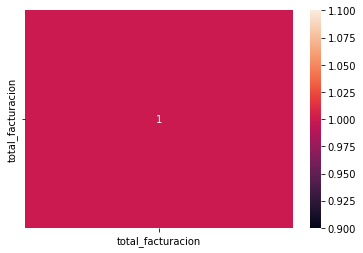

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo las columnas relevantes
df_filtered = df[[ 'total_facturacion', 'marca']]

# Crear un mapa de correlación con Seaborn
sns.heatmap(df_filtered.corr(), annot=True)

# Mostrar el mapa
plt.show()
